If you are running this notebook on Google Colab, you can mount your Google Drive to save the data and load them later. To do this, uncomment the following code and follow the instructions.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
## install the required packages. This may take a few minutes. 

%pip install medmnist
%pip install tensorflow==2.15.0
%pip install matplotlib
%pip install lime
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
## import the required packages. 

import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import os
from medmnist.dataset import PneumoniaMNIST
import random
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

2024-05-24 10:29:45.432985: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 10:29:45.479850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 10:29:45.479931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 10:29:45.481582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-24 10:29:45.488975: I tensorflow/core/platform/cpu_feature_guar

In [4]:
## set the seeds and enable deterministic operations for reproducibility.

os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()
kseed=0
np.random.seed(kseed)
random.seed(kseed)
tf.random.set_seed(kseed)
tf.keras.utils.set_random_seed(kseed)

In [5]:
## set the input and output directories. You can change the input directory to any directory where you want to save the data.

input_root = '/home/biosim/Fanis/ISBI'
output_root = os.path.join(input_root, 'PneumoniaMNIST')
if not os.path.isdir(output_root):
    os.makedirs(output_root)

In [6]:
## download the PneumoniaMNIST dataset and load the data.

_ = PneumoniaMNIST(split="train", root=input_root, download=True, size=224)

Using downloaded and verified file: /home/biosim/Fanis/ISBI/pneumoniamnist_224.npz


In [7]:
## split the data.

npz_file = np.load(os.path.join(input_root, "pneumoniamnist_224.npz"))

x_train = npz_file['train_images']
x_train = np.repeat(x_train[..., np.newaxis], 3, axis=-1)
y_train = npz_file['train_labels']

x_val = npz_file['val_images']
x_val = np.repeat(x_val[..., np.newaxis], 3, axis=-1)
y_val = npz_file['val_labels']

x_test = npz_file['test_images']
x_test = np.repeat(x_test[..., np.newaxis], 3, axis=-1)
y_test = npz_file['test_labels']

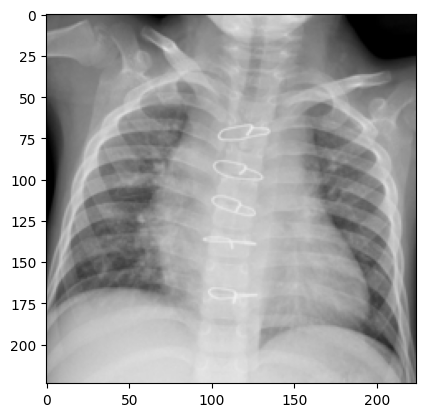

In [8]:
## display the first image in the training set.

plt.imshow(x_train[0])

In [9]:
## define a function to create a ResNet50 model.

def create_model(pooling='max', lr=0.001):
    """
    This function creates a ResNet50 model.

    Parameters:
    pooling (str): the type of global pooling to be applied, default is 'max'
    lr (float): learning rate, default is 0.001

    Returns:
    model (tf.keras.models.Model): the compiled model
    """
    tf.keras.backend.clear_session()

    i = tf.keras.layers.Input([224, 224, 3], dtype="uint8")
    x = tf.keras.layers.Lambda(lambda x: tf.cast(x, "float32"))(i)
    preprocess_input = tf.keras.applications.resnet_v2.preprocess_input(x)

    pretrained_model = tf.keras.applications.ResNet50V2(include_top=False, pooling=pooling, weights='imagenet', input_tensor=preprocess_input)

    x = pretrained_model.output
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    out = tf.keras.layers.Dense(2, activation='softmax')(x)
    model = tf.keras.models.Model(i, outputs=out)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='CategoricalCrossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(name='auc'),
                           tf.keras.metrics.AUC(curve='PR', name='auprc')]
                  )
    return model

In [10]:
model = create_model()

2024-05-24 10:29:57.736125: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 10:29:57.737806: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 10:29:57.738034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)          0         ['lambda[0][0]']              
 a)                                                                                               
                                                                                                  
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)          0         ['tf.math.truediv[0][0]'] 

In [11]:
## train the model.

y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_val_one_hot = tf.keras.utils.to_categorical(y_val)
history = model.fit(x_train, y_train_one_hot, epochs=100, validation_data=(x_val, y_val_one_hot),
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                                                mode='max',
                                                                patience=30,
                                                                verbose=1,
                                                                restore_best_weights=True)]
                    )

Epoch 1/100


2024-05-17 13:27:52.907932: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-05-17 13:27:57.860235: I external/local_xla/xla/service/service.cc:168] XLA service 0x72b8c89474d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-17 13:27:57.860275: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-17 13:27:58.010516: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715941678.386410  414558 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 [==============================] - 107s 241ms/step - loss: 1.0805 - accuracy: 0.9339 - precision: 0.9339 - recall: 0.9339 - auc: 0.9674 - auprc: 0.9600 - val_loss: 0.7250 - val_accuracy: 0.9389 - val_precision: 0.9389 - val_recall: 0.9389 - val_auc: 0.9641 - val_auprc: 0.9546
Epoch 2/100
148/148 [==============================] - 30s 204ms/step - loss: 0.1010 - accuracy: 0.9677 - precision: 0.9677 - recall: 0.9677 - auc: 0.9941 - auprc: 0.9936 - val_loss: 0.1221 - val_accuracy: 0.9733 - val_precision: 0.9733 - val_recall: 0.9733 - val_auc: 0.9865 - val_auprc: 0.9835
Epoch 3/100
148/148 [==============================] - 30s 206ms/step - loss: 0.0599 - accuracy: 0.9781 - precision: 0.9781 - recall: 0.9781 - auc: 0.9974 - auprc: 0.9972 - val_loss: 0.1234 - val_accuracy: 0.9580 - val_precision: 0.9580 - val_recall: 0.9580 - val_auc: 0.9909 - val_auprc: 0.9897
Epoch 4/100
148/148 [==============================] - 30s 201ms/step - loss: 0.0489 - accuracy: 0.9826 - precision: 0.9826

In [12]:
## save the model weights.

model.save_weights(os.path.join(input_root, 'model.weights.h5'))

In [11]:
## load the model weights.

model.load_weights(os.path.join(input_root, 'model.weights.h5'))

In [12]:
## evaluate the model.

y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_labels)
roc_auc = roc_auc_score(y_test, y_pred[:, 1])
f1 = f1_score(y_test, y_pred_labels)
confusion = confusion_matrix(y_test, y_pred_labels)

print("Confusion Matrix:")
print(confusion)

print("Accuracy: ", accuracy)
print("ROC AUC: ", roc_auc)
print("F1 Score: ", f1)

2024-05-24 10:30:03.319475: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


20/20 [==============================] - 5s 101ms/step
Confusion Matrix:
[[170  64]
 [  2 388]]
Accuracy:  0.8942307692307693
ROC AUC:  0.9796789392943239
F1 Score:  0.9216152019002375


In [13]:
## create four lists to hold the indices of the true positives, true negatives, false positives, and false negatives.

# Initialize lists to hold the indices of each category
true_positives = []
true_negatives = []
false_positives = []
false_negatives = []

# Iterate over the test set and categorize each image
for i in range(len(y_test)):
    # True positives
    if y_test[i] == 1 and y_pred_labels[i] == 1:
        true_positives.append(i)
    # True negatives
    elif y_test[i] == 0 and y_pred_labels[i] == 0:
        true_negatives.append(i)
    # False positives
    elif y_test[i] == 0 and y_pred_labels[i] == 1:
        false_positives.append(i)
    # False negatives
    elif y_test[i] == 1 and y_pred_labels[i] == 0:
        false_negatives.append(i)

# Select one image from each category
tn_i = true_negatives[np.random.randint(len(true_negatives))]
fn_i = false_negatives[np.random.randint(len(false_negatives))]
fp_i = false_positives[np.random.randint(len(false_positives))]
tp_i = true_positives[np.random.randint(len(true_positives))]

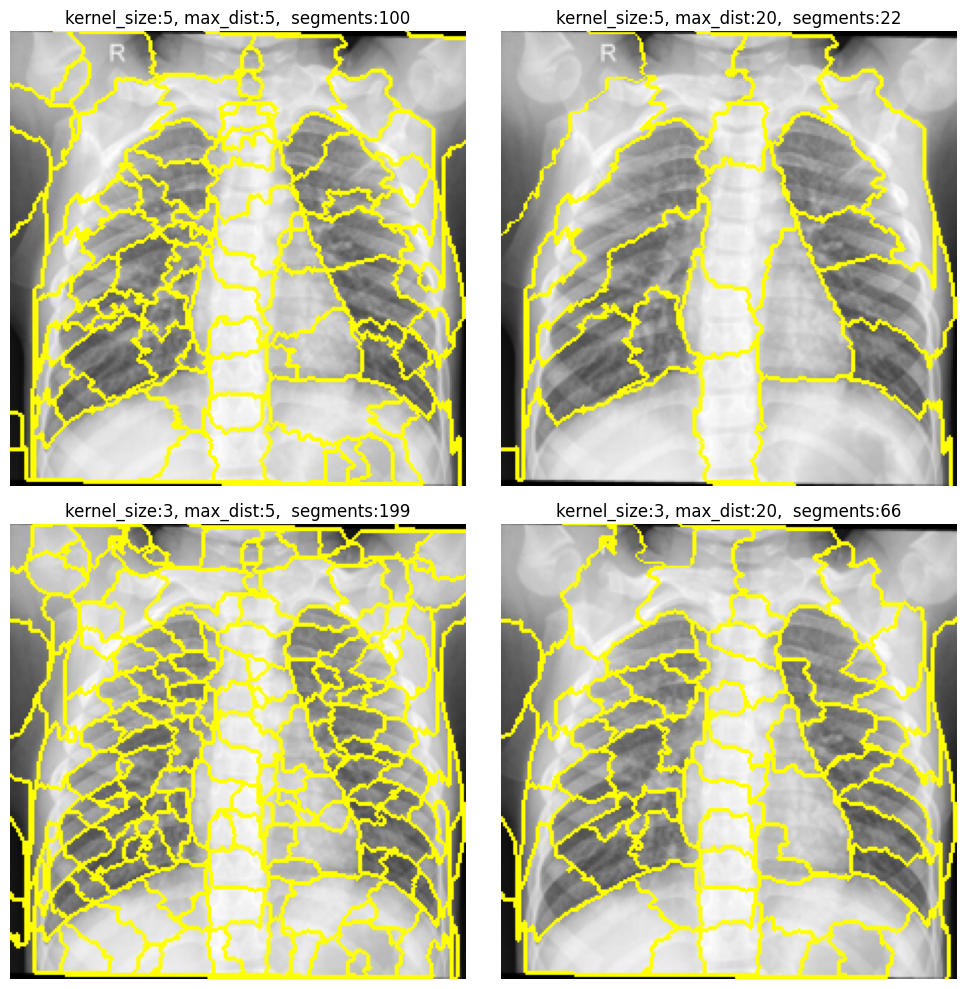

In [14]:
## display the impact of different segmentation parameters on the image.

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, seg_args in enumerate([{'kernel_size':5, 'max_dist':5},
                           {'kernel_size':5, 'max_dist':20},
                           {'kernel_size':3, 'max_dist':5},
                           {'kernel_size':3, 'max_dist':20}]):

    segments = SegmentationAlgorithm('quickshift', **seg_args, ratio=0.2)(x_test[tn_i, ...])

    ax[i//2, i%2].imshow(mark_boundaries(x_test[tn_i, ...], segments))
    ax[i//2, i%2].set_title(f'kernel_size:{seg_args["kernel_size"]}, max_dist:{seg_args["max_dist"]},  segments:{len(np.unique(segments))}')
    

    for a in ax.ravel():
        a.set_axis_off()

plt.tight_layout()
plt.show()

In [15]:
## define a function to display the LIME explanation.

def display_lime(image, samples, axs):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image=image, top_labels=1, batch_size=100,
                                             classifier_fn=lambda x: model.predict(x, verbose=0), num_samples=samples,
                                             segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=3, max_dist=20, ratio=0.2))

    _, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    heatmap = np.vectorize(dict(explanation.local_exp[explanation.top_labels[0]]).get)(explanation.segments)*np.abs(mask)

    axs.imshow(mark_boundaries(image, explanation.segments))
    axs.imshow(heatmap, cmap = 'PiYG', vmin  = -np.abs(heatmap).max(), vmax = np.abs(heatmap).max(), alpha=0.5)
    
    axs.axis('off')

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

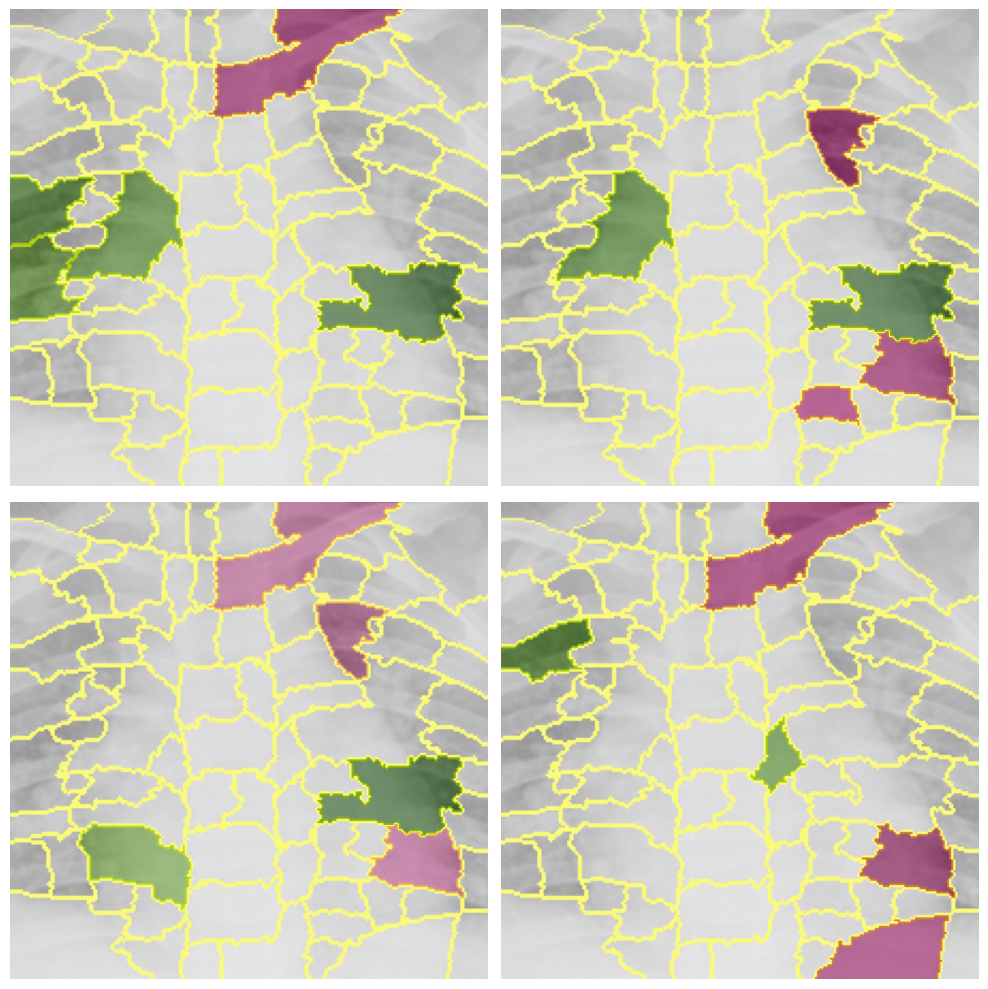

In [16]:
## display the impact of low number of samples on the image explanation.

fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over it

for i in range(4):
    display_lime(x_test[tp_i, ...], 100, axs[i])

plt.tight_layout()
plt.show()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

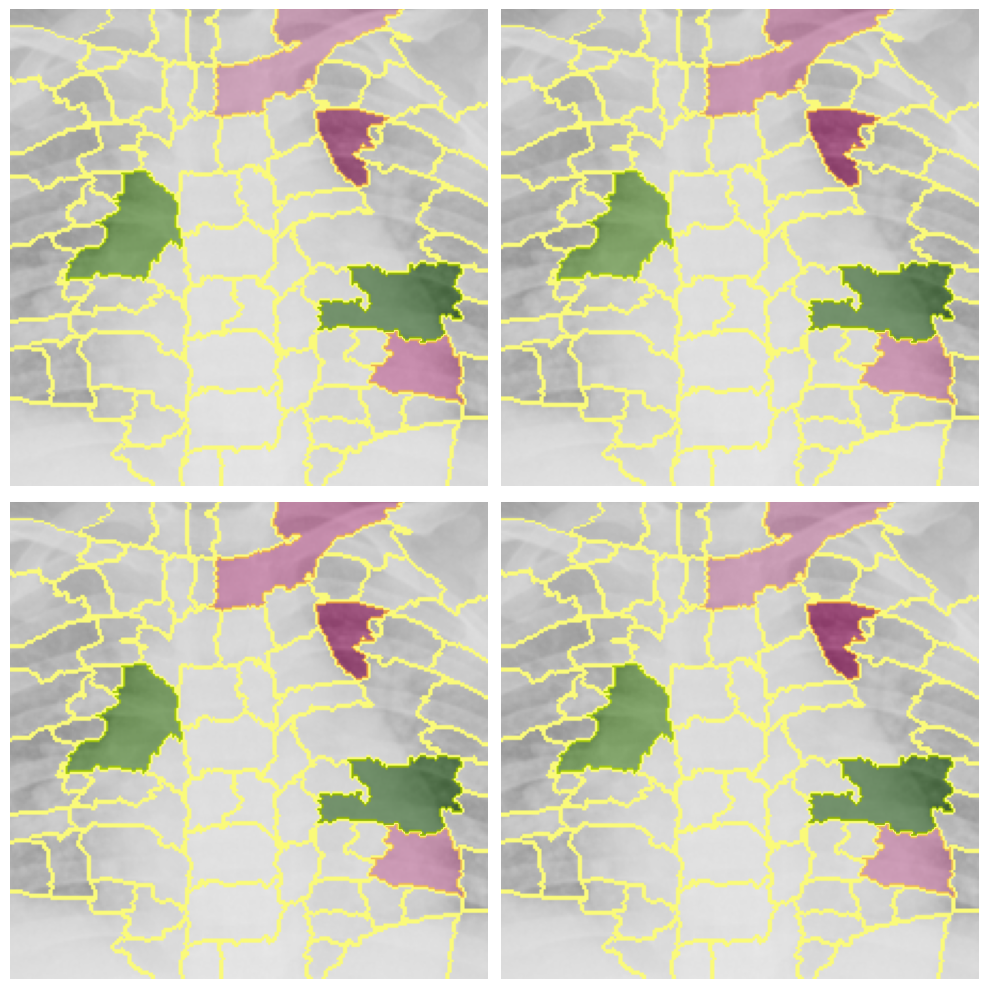

In [17]:
## display the impact of high number of samples on the image explanation.

fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid of subplots
axs = axs.ravel()  # Flatten the grid to easily iterate over it

for i in range(4):
    display_lime(x_test[tp_i, ...], 6000, axs[i])

plt.tight_layout()
plt.show()

  0%|          | 0/6000 [00:00<?, ?it/s]

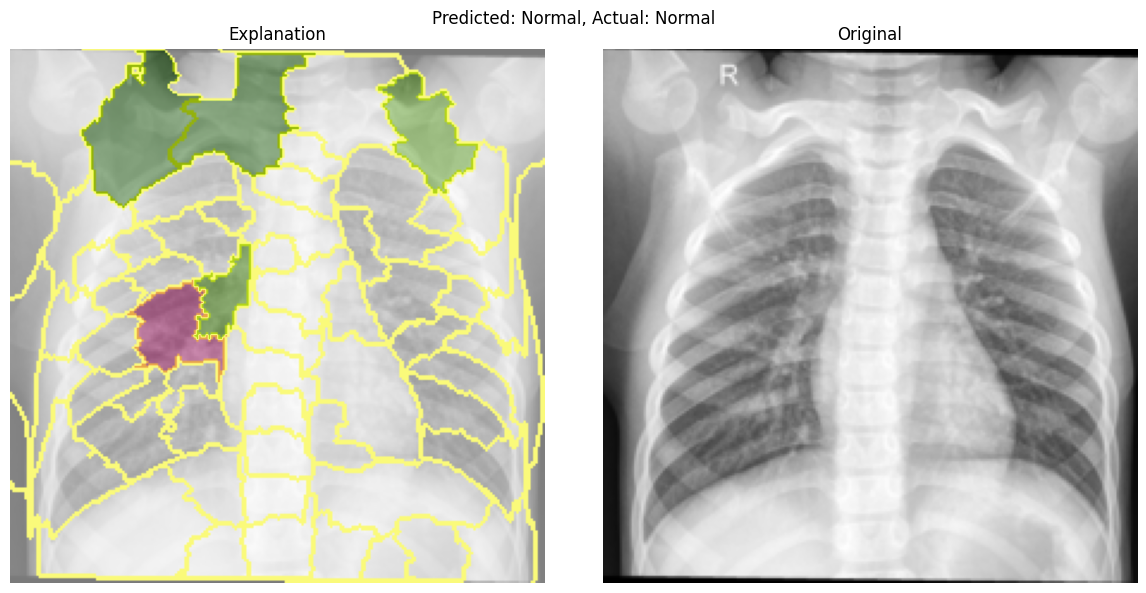

  0%|          | 0/6000 [00:00<?, ?it/s]

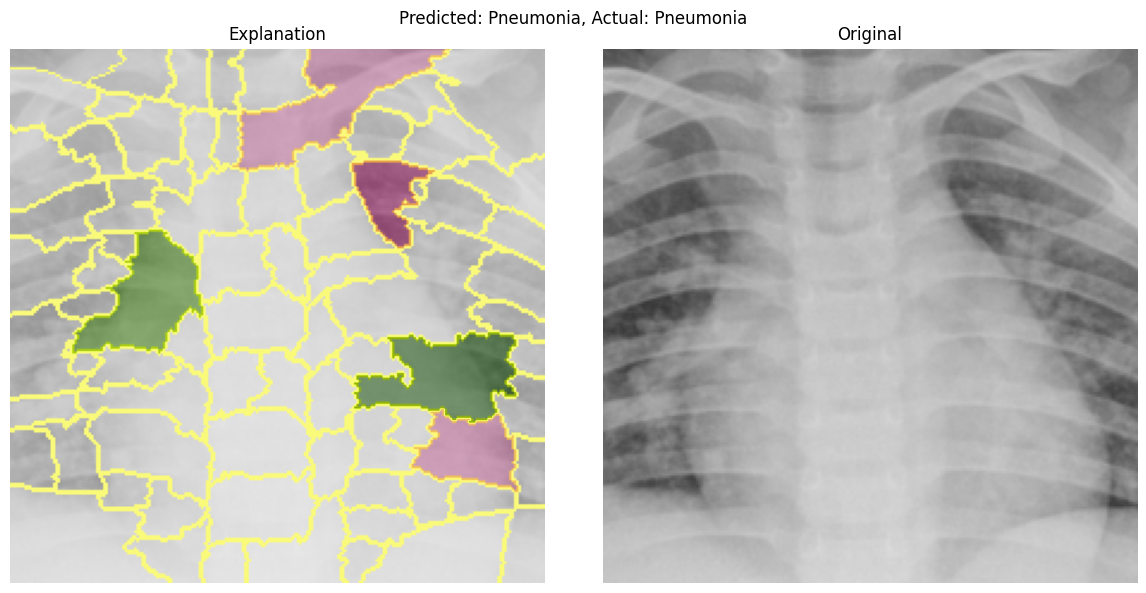

  0%|          | 0/6000 [00:00<?, ?it/s]

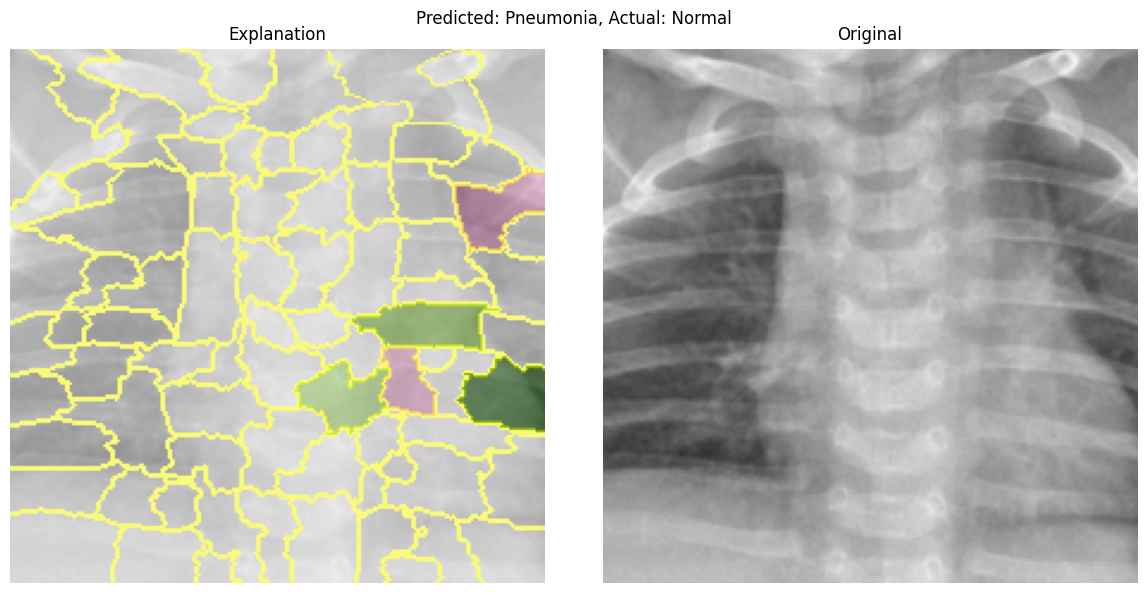

  0%|          | 0/6000 [00:00<?, ?it/s]

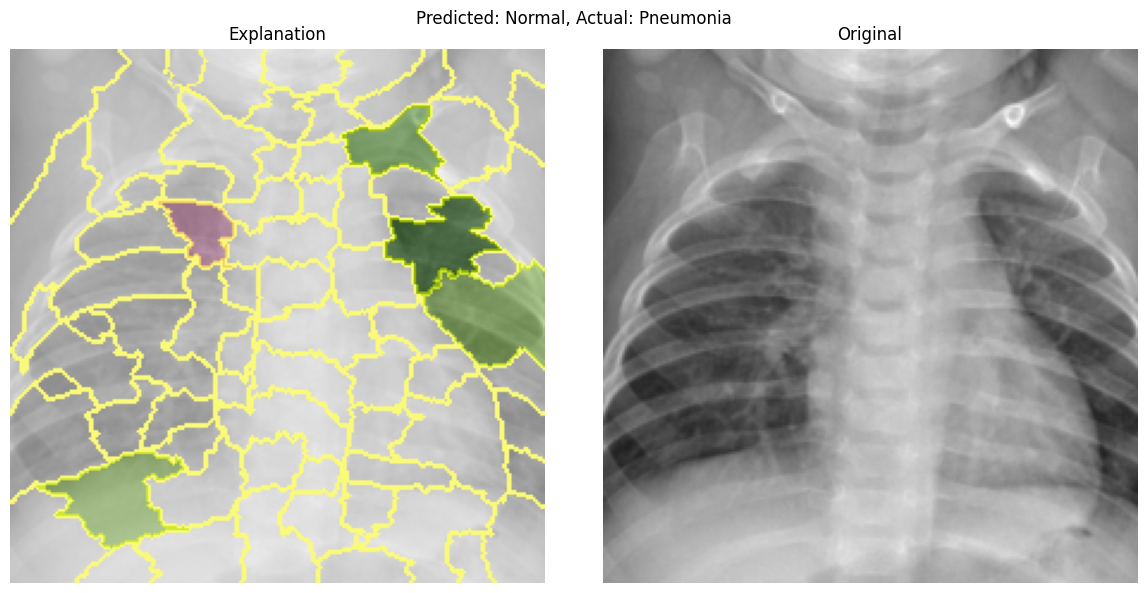

In [18]:
## display the LIME explanation for the four selected images.

for i, image_i in enumerate([tn_i, tp_i, fp_i, fn_i]):
    
    preds = model.predict(x_test[image_i:image_i+1, ...], verbose=0)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a 2x2 grid of subplots
    fig.suptitle(f"Predicted: {'Pneumonia' if preds[:, 1]>0.5 else 'Normal'}, Actual: {'Pneumonia' if y_test[image_i]>0.5 else 'Normal'}")

    display_lime(x_test[image_i, ...], 6000, axs[0])
    
    axs[1].imshow(x_test[image_i, ...])
    axs[1].axis('off')    
    
    axs[0].set_title('Explanation')
    axs[1].set_title('Original')
    
    plt.tight_layout()
    plt.show()

In [19]:
## define a function to generate and display a Grad-CAM heatmap.

def make_gradcam_heatmap(img_array, model, pred_index=None):
    """
    This function generates a Grad-CAM heatmap for a given image.

    Parameters:
    img_array (np.array): the input image
    model (tf.keras.models.Model): the model
    pred_index (int): the index of the class to visualize

    Returns:
    heatmap (np.array): the generated heatmap
    """
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer('post_relu').output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, ax, alpha=0.4):
    """
    This function displays a Grad-CAM heatmap on an image.

    Parameters:
    img (np.array): the input image
    heatmap (np.array): the heatmap to display
    ax (matplotlib.axes.Axes): the axes to plot on
    alpha (float): the transparency of the heatmap
    """
    ax.imshow(np.flipud(img))
    ax.axis('off')
    i = ax.imshow(heatmap, alpha=alpha, cmap='jet', interpolation='bilinear', extent=(0, img.shape[1], 0, img.shape[0]))
    plt.colorbar(i, ax=ax)

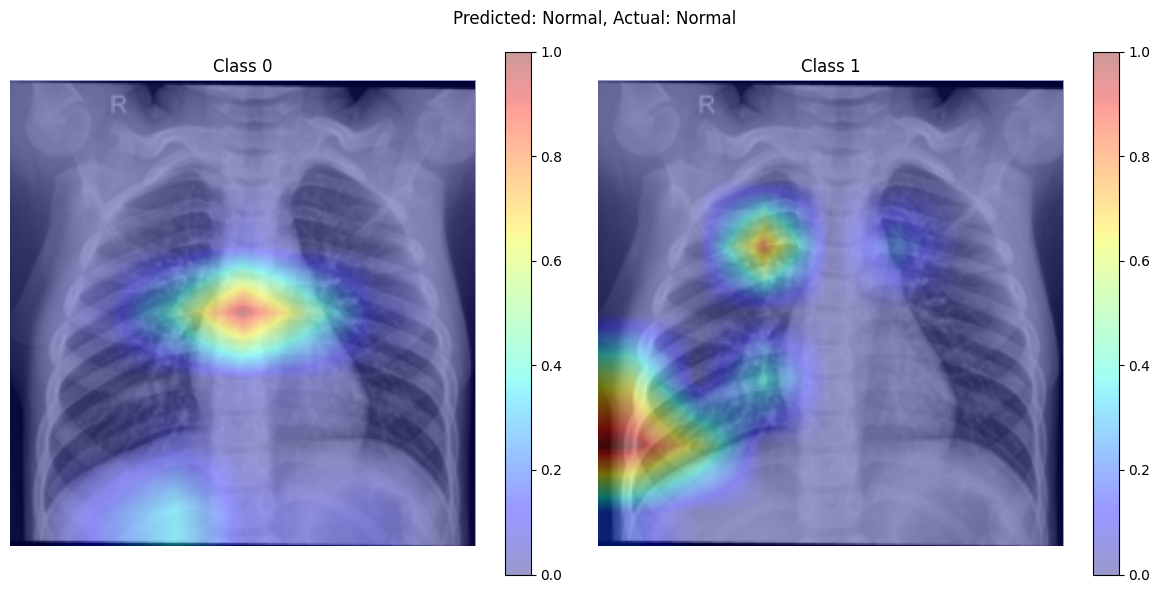

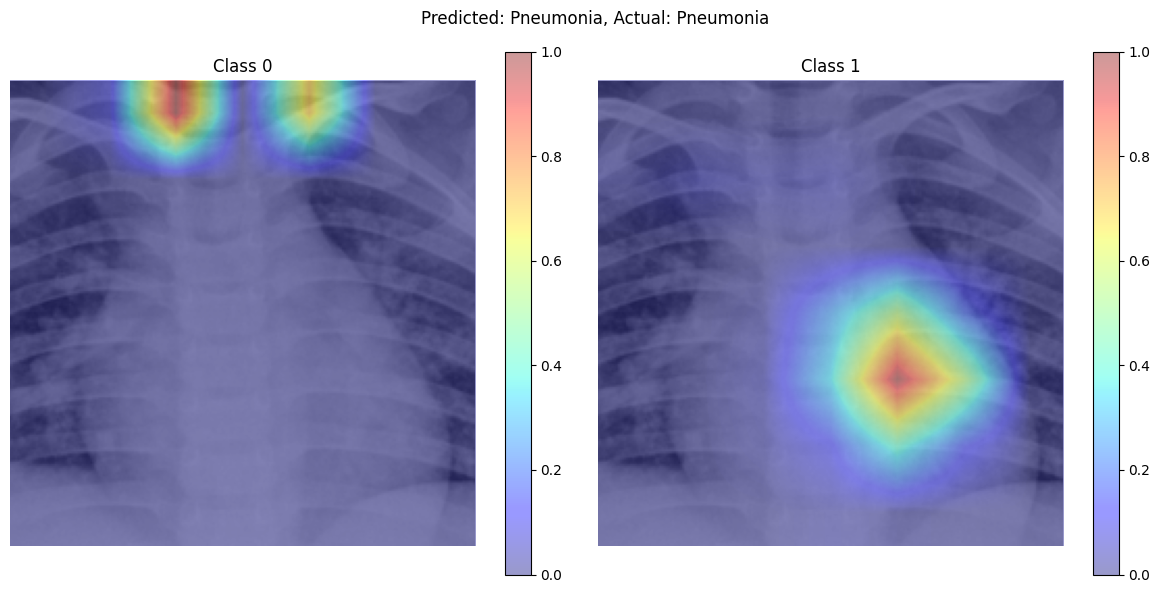

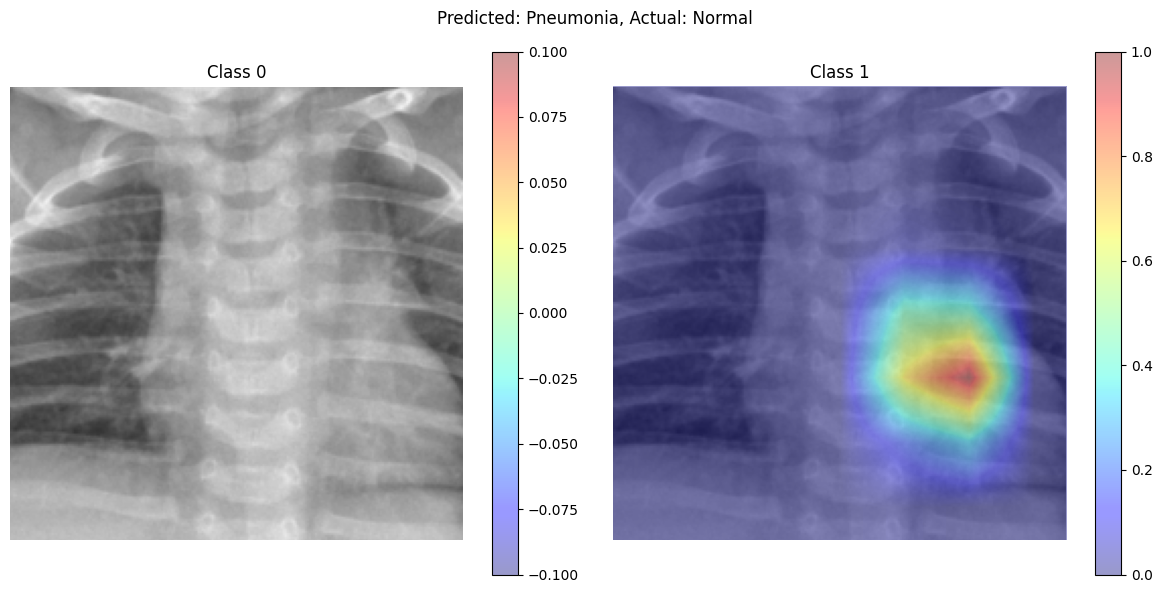

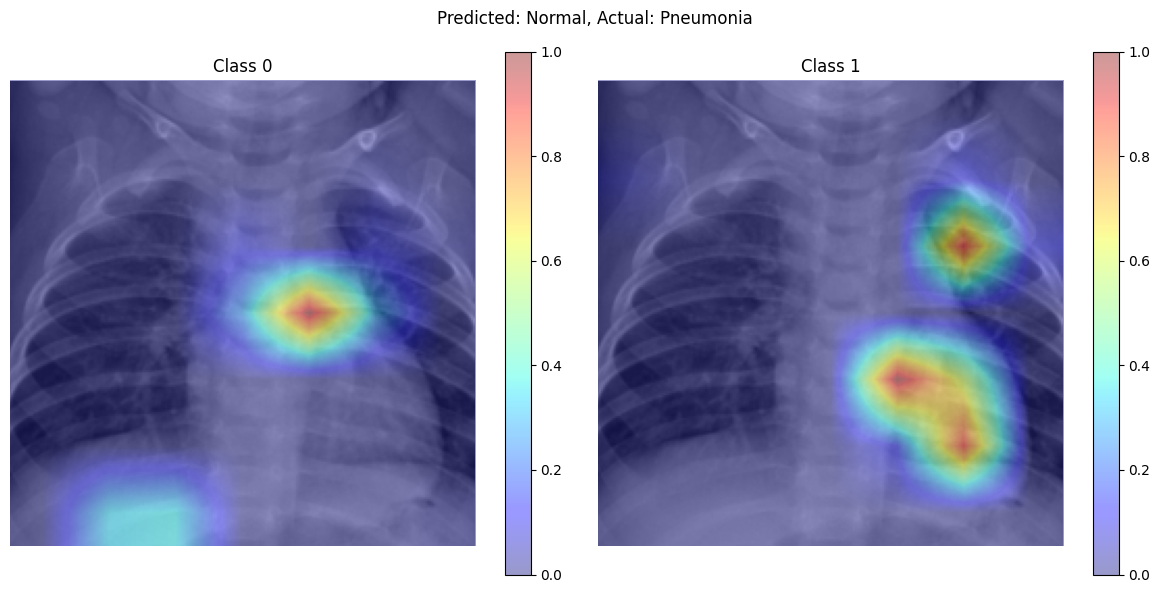

In [20]:
## display the Grad-CAM heatmap for the four selected images.

for i, image_i in enumerate([tn_i, tp_i, fp_i, fn_i]):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a 2x2 grid of subplots
    
    preds = model.predict(x_test[image_i:image_i+1, ...], verbose=0)
    fig.suptitle(f"Predicted: {'Pneumonia' if preds[:, 1]>0.5 else 'Normal'}, Actual: {'Pneumonia' if y_test[image_i]>0.5 else 'Normal'}")
    
    heatmap = make_gradcam_heatmap(x_test[image_i:image_i+1, ...], model, pred_index=0)
    display_gradcam(x_test[image_i, ...], heatmap, axs[0])
    axs[0].set_title('Class 0')

    heatmap = make_gradcam_heatmap(x_test[image_i:image_i+1, ...], model, pred_index=1)
    display_gradcam(x_test[image_i, ...], heatmap, axs[1])
    axs[1].set_title('Class 1')
    plt.tight_layout()
    plt.show()

Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. Yang, Jiancheng, et al. "MedMNIST v2-A large-scale lightweight benchmark for 2D and 3D biomedical image classification." Scientific Data, 2023.

Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis". IEEE 18th International Symposium on Biomedical Imaging (ISBI), 2021.

Daniel S. Kermany, Michael Goldbaum, et al., "Identifying medical diagnoses and treatable diseases by image-based deep learning," Cell, vol. 172, no. 5, pp. 1122 – 1131.e9, 2018.